In [1]:
# ================================================
# 🧠 Notebook 4: Model Explainability (Grad-CAM)
# ================================================

# --- Step 1: Imports ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import os

# --- Step 2: Load trained model ---
model_path = "fracture_detection_mobilenetv2.h5"
model = load_model(model_path)
print("✅ Model loaded successfully!")




✅ Model loaded successfully!


In [2]:
# --- Step 3: Grad-CAM Function Definition ---
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the top predicted class w.r.t. last conv layer
    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]

    # Multiply each channel by its importance
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [3]:
# --- Step 4: Load and Preprocess Image ---
def preprocess_img(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array, img

In [4]:
# --- Step 5: Apply Grad-CAM on Sample Image ---
img_path = "../Datasets/Bone_Fracture_Detection/test/fractured/001.png"  # change path as needed
img_array, img = preprocess_img(img_path)

# Get model prediction
pred = model.predict(img_array)
classes = ['fractured', 'not fractured']
pred_class = classes[int(np.round(pred[0][0]))]
print(f"🩻 Predicted: {pred_class} ({pred[0][0]*100:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
🩻 Predicted: fractured (36.82% confidence)


In [5]:
# --- Step 6: Generate Grad-CAM heatmap ---
last_conv_layer_name = "Conv_1"  # MobileNetV2 final conv layer
heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

# --- Step 7: Overlay Heatmap on Original Image ---
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(img), 1-alpha, heatmap, alpha, 0)
    return superimposed_img

superimposed_img = overlay_heatmap(img, heatmap)



C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


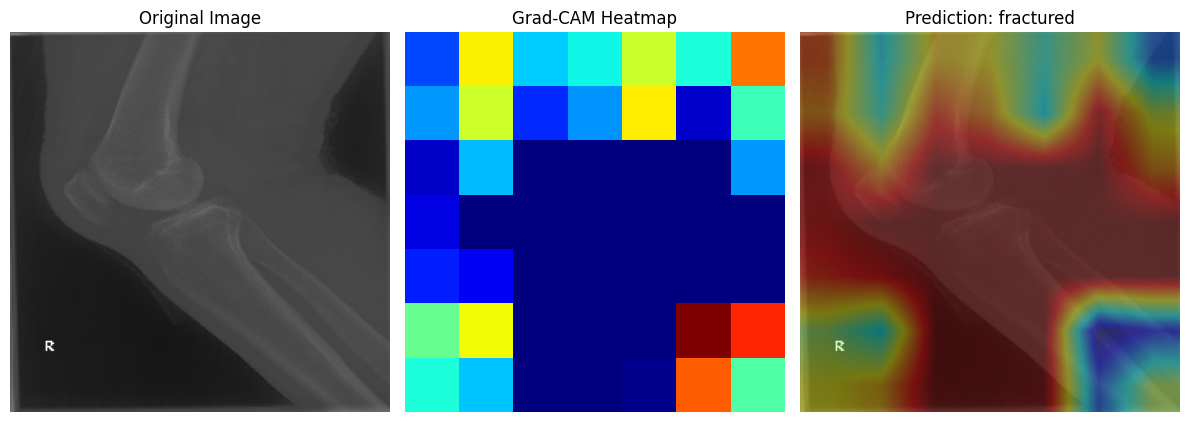

In [6]:
# --- Step 8: Display Results ---
plt.figure(figsize=(12,6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title(f"Prediction: {pred_class}")
plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
⚠️ Skipping ../Datasets/Bone_Fracture_Detection/test\fractured\8-rotated3-rotated1 - Copy.jpg due to error: name 'class_labels' is not defined
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
⚠️ Skipping ../Datasets/Bone_Fracture_Detection/test\fractured\82-rotated3-rotated2-rotated1.jpg due to error: name 'class_labels' is not defined
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
⚠️ Skipping ../Datasets/Bone_Fracture_Detection/test\fractured\3-rotated2-rotated1-rotated1 - Copy.jpg due to error: name 'class_labels' is not defined
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
⚠️ Skipping ../Datasets/Bone_Fracture_Detection/test\fractured\85-rotated1-rotated1-rotated1.jpg due to error: name 'class_labels' is not defined
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
⚠️ Skipping ../Datasets/Bone_Fracture_Detection/test\fractured\81-rotated2-rotated3-rotated3.jpg due to error: name 'class_labels' is not defined
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
⚠️ Skipping ../Datasets/Bone_Fracture_D

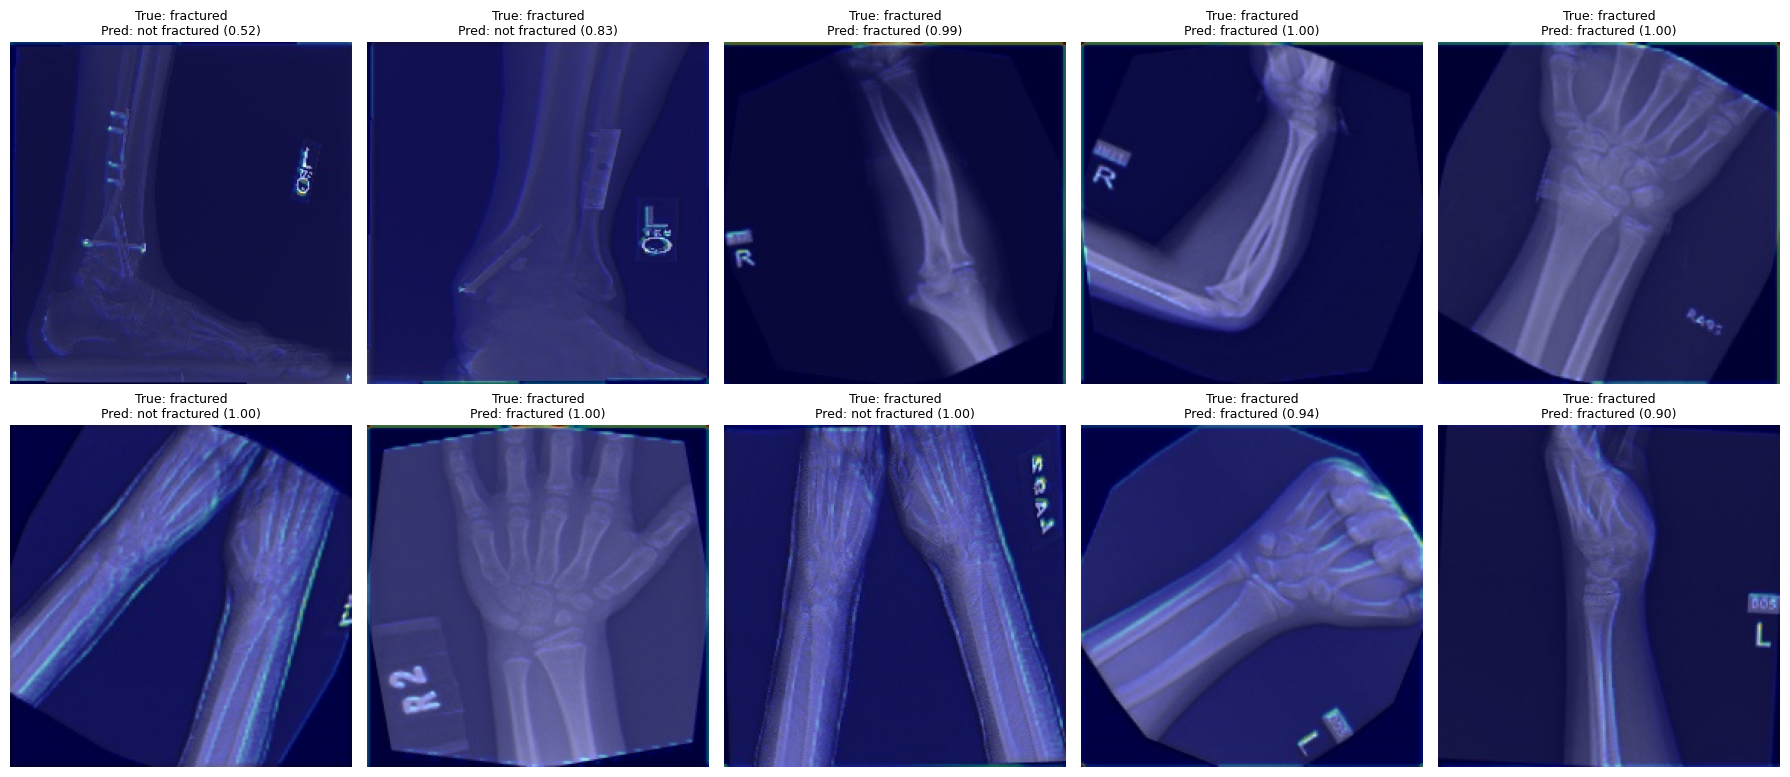

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, random, os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

for img_path in sample_paths:
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        preds = model.predict(img_array)
        pred_class = np.argmax(preds[0])
        print(f"{os.path.basename(img_path)} -> {class_labels[pred_class]}")
    except Exception as e:
        print(f"⚠️ Skipping {img_path} due to error: {e}")

# --- Directory containing your test images ---
test_dir = "../Datasets/Bone_Fracture_Detection/test"  # update this path if needed

# --- Subdirectories for each class ---
classes = ["fractured", "not fractured"]

# --- Grad-CAM Helper Function ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- Get a few random test images ---
n_samples = 10
sample_paths = []
for c in classes:
    class_path = os.path.join(test_dir, c)
    imgs = os.listdir(class_path)
    random_imgs = random.sample(imgs, n_samples//2)
    sample_paths.extend([os.path.join(class_path, i) for i in random_imgs])

# --- Layer name of the last convolutional layer ---
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

# --- Output folder ---
os.makedirs("gradcam_outputs", exist_ok=True)

# --- Generate Grad-CAMs ---
for img_path in sample_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    preds = model.predict(img_array)
   # pred_class = classes[int(preds[0] < 0.5)]
    #confidence = float(preds[0] if preds[0] > 0.5 else 1 - preds[0])
    pred_val = float(preds[0][0])  # extract scalar
    pred_class = classes[int(pred_val < 0.5)]
    confidence = pred_val if pred_val > 0.5 else 1 - pred_val


    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # --- Superimpose heatmap on original image ---
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # --- Save result ---
    fname = os.path.basename(img_path).split('.')[0]
    save_path = f"gradcam_outputs/{fname}_{pred_class}_{confidence:.2f}.jpg"
    cv2.imwrite(save_path, superimposed_img)
    print(f"✅ Saved: {save_path}")

# --- Display Grad-CAMs with labels ---
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
for ax, img_name in zip(axes.flatten(), os.listdir("gradcam_outputs")[:10]):
    img_path = os.path.join("gradcam_outputs", img_name)
    img = plt.imread(img_path)

    # Extract prediction and confidence from filename
    parts = img_name.split("_")
    pred_label = parts[-2]
    conf = parts[-1].replace(".jpg", "")
    
    # Try to infer true label from filename
    if "fractured" in img_name.lower():
        true_label = "fractured"
    elif "not" in img_name.lower():
        true_label = "not fractured"
    else:
        true_label = "unknown"

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({conf})", fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()
    


